In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('AirPassengers.csv')

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
data['Month'] = data['Month'].apply(lambda x:dt(int(x[:4]),int(x[5:]),15))
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


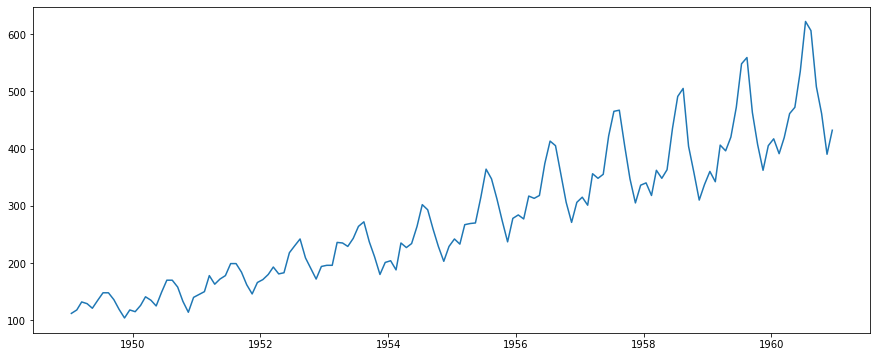

In [9]:
ts = data['#Passengers']
plt.plot(ts)

In [10]:
ts_log = np.log(ts)

In [13]:
def test_stationarity(timeseries):
    rollmean = timeseries.rolling(window = 52, center = False).mean()
    rollstd = timeseries.rolling(window = 52, center = False).std()
    
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rollmean,color='red',label='Rolling Mean')
    std = plt.plot(rollstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean and std')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller test:')
    df_test = adfuller(timeseries,autolag='AIC')
    df_output = pd.Series(df_test[0:4],index=['Test Statistic','p-value','#Lags used','#Observations used'])
    for key,value in df_test[4].items():
        df_output['Critical value(%s)'%key] = value
    print(df_output)
    

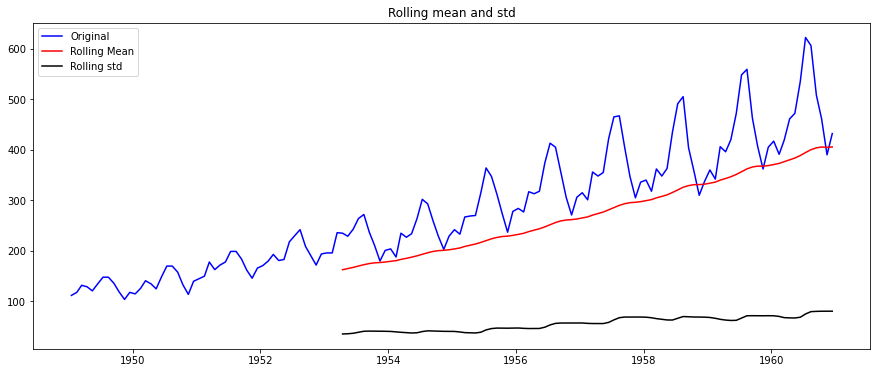

Results of Dickey-Fuller test:
Test Statistic           0.815369
p-value                  0.991880
#Lags used              13.000000
#Observations used     130.000000
Critical value(1%)      -3.481682
Critical value(5%)      -2.884042
Critical value(10%)     -2.578770
dtype: float64


In [14]:
test_stationarity(data['#Passengers'])

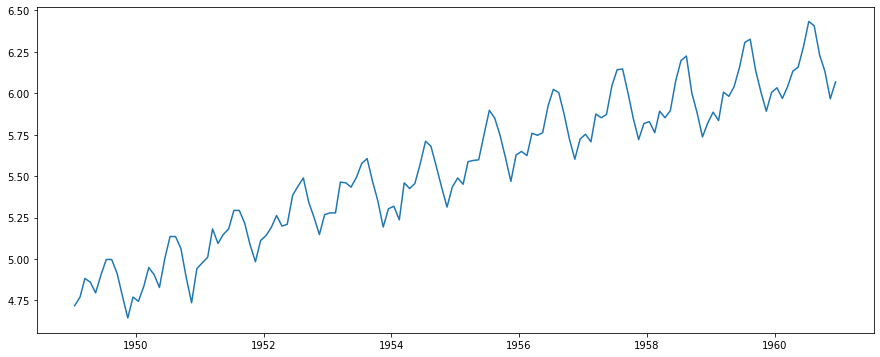

In [15]:
plt.plot(ts_log)

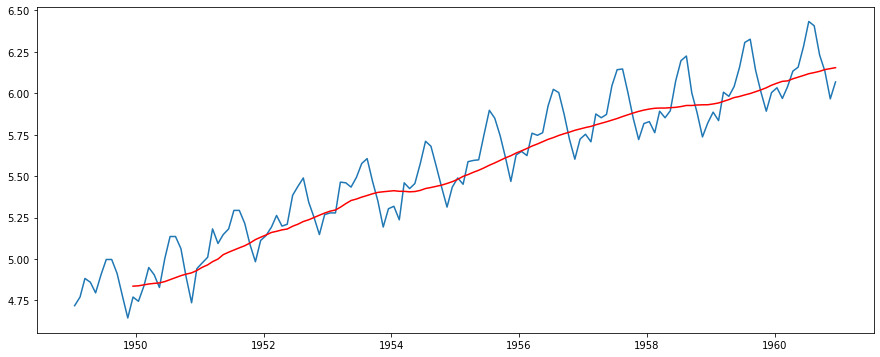

In [16]:
movingavg = ts_log.rolling(window=12).mean()
movingstd = ts_log.rolling(window=12).std()

plt.plot(ts_log)
plt.plot(movingavg,color='red')

In [17]:
ts_log_mvdiff = ts_log-movingavg
ts_log_mvdiff.dropna(inplace=True)
ts_log_mvdiff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

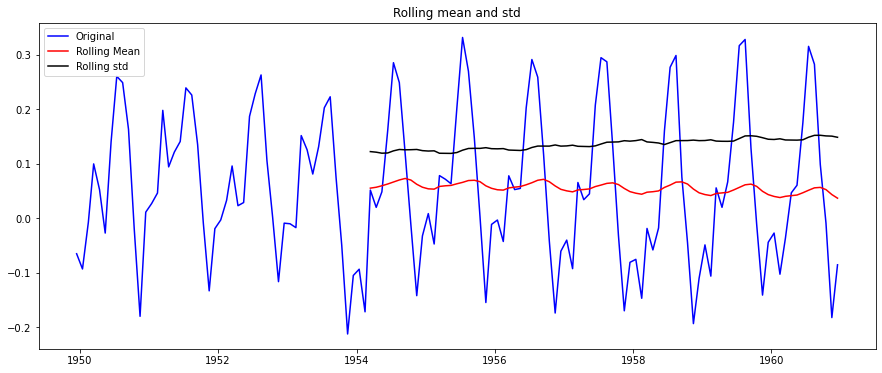

Results of Dickey-Fuller test:
Test Statistic          -3.162908
p-value                  0.022235
#Lags used              13.000000
#Observations used     119.000000
Critical value(1%)      -3.486535
Critical value(5%)      -2.886151
Critical value(10%)     -2.579896
dtype: float64


In [18]:
test_stationarity(ts_log_mvdiff)

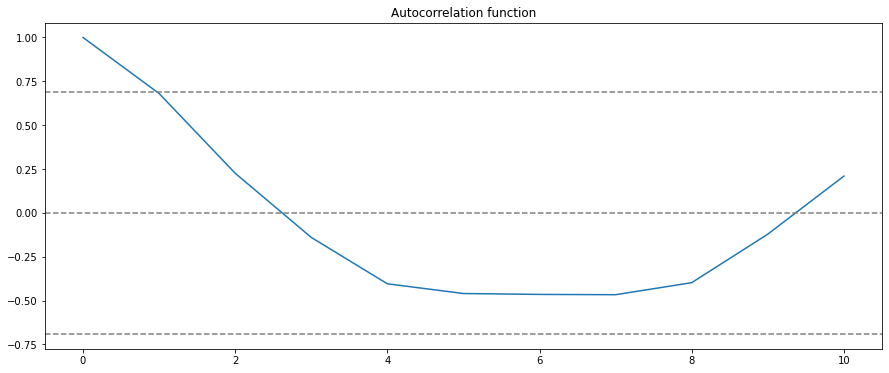

In [21]:
plt.plot(np.arange(0,11),acf(ts_log_mvdiff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mvdiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mvdiff)),linestyle='--',color='gray')
plt.title('Autocorrelation function')
plt.show()

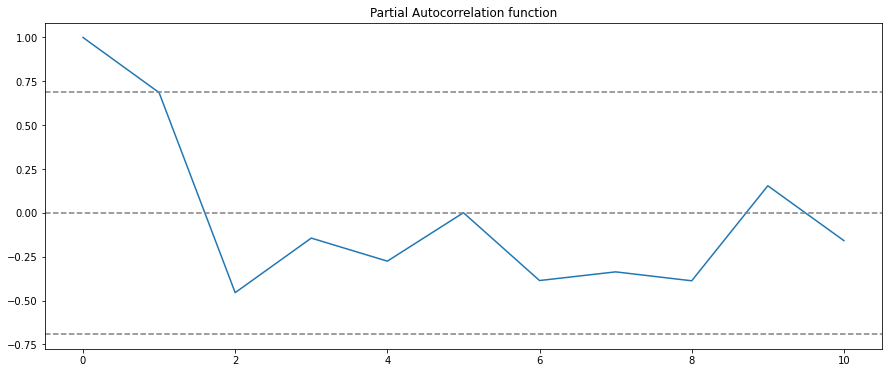

In [22]:
plt.plot(np.arange(0,11),pacf(ts_log_mvdiff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mvdiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mvdiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation function')
plt.show()

Text(0.5, 1.0, 'RSS: nan')

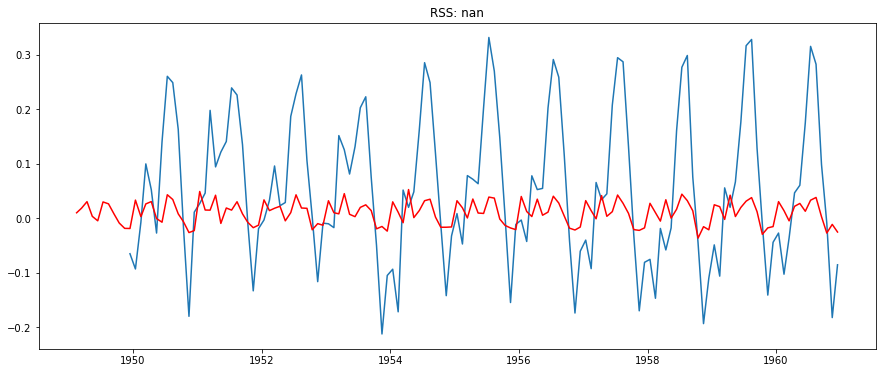

In [23]:
model = ARIMA(ts_log,order=(1,1,0))
results = model.fit(disp=-1)
plt.plot(ts_log_mvdiff)
plt.plot(results.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results.fittedvalues[1:]-ts_log_mvdiff)**2))

In [24]:
predictions = pd.Series(results.fittedvalues,copy=True)
predictions.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [26]:
predictions_cumsum = predictions.cumsum()
predictions_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [28]:
predictions_log = pd.Series(ts_log[0],index=ts_log.index)
predictions_log = predictions_log.add(predictions_cumsum,fill_value=0)
predictions_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

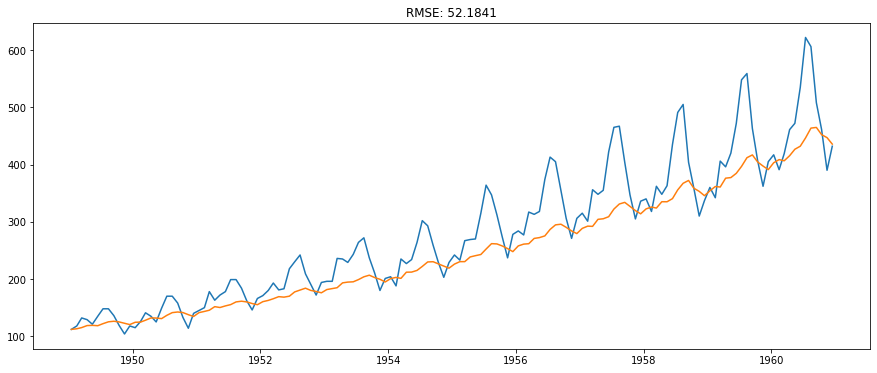

In [30]:
predictions_ARIMA = np.exp(predictions_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

Our model is good at predicting trend but fails to capture the seasonality.